In [81]:
import os
#os.getcwd() # '/home/osboxes/Documents/Projet'
import re
import csv
import time
import pandas as pd
import numpy as np
from random import randint

from pytrends.request import TrendReq
import json
import pymongo                          
from pymongo import MongoClient
import datetime as dd

#import datetime
from dateutil.parser import parse

import pprint
import matplotlib.pyplot as plt

from scipy import stats

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
#clf = linear_model.LinearRegression()
#clf.fit(X,y)

import xlrd
import openpyxl

%matplotlib 
%pylab inline
import pylab


Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


### On importe les données du modèle reduit sans les valeurs manquantes

In [86]:
pd.ExelFile?

Object `pd.ExelFile` not found.


In [87]:
xls_file = pd.ExcelFile('input_video_game_final.xlsx',index_col=0)

In [89]:
train = xls_file.parse('y_x',index_col=0)
train.head()

pos           publisher platform  \
_id                                                          
5853f723bcb6cea84d670b5d    3            Nintendo      3DS   
5853f723bcb6cea84d670b63    6            Nintendo      3DS   
5853f723bcb6cea84d670b65    7          Activision      Wii   
5853f723bcb6cea84d670b69    9            Nintendo      Wii   
5853f723bcb6cea84d670b6f   12  Bethesda Softworks     X360   

                                                   game         genre  \
_id                                                                     
5853f723bcb6cea84d670b5d                   Mario Kart 7        Racing   
5853f723bcb6cea84d670b63            Super Mario 3D Land      Platform   
5853f723bcb6cea84d670b65  Skylanders: Spyro's Adventure        Action   
5853f723bcb6cea84d670b69                 Mario Kart Wii        Racing   
5853f723bcb6cea84d670b6f    The Elder Scrolls V: Skyrim  Role-Playing   

                          diff_release_date  mois  quarter  Y_delta_vg  \
_id                                                                      
5853f723bcb6cea84d670b5d                 18    12        4          -1   
5853f723bcb6cea84d670b63                 38    12        4          -1   
5853f723bcb6cea84d670b65                 43    12        4           1   
5853f723bcb6cea84d670b69               1336    12        4           1   
5853f723bcb6cea84d670b6f                 37    12        4           1   

                          delta_vg_s  delta_gg_sm1  delta_gp_sm1  \
_id                                                                
5853f723bcb6cea84d670b5d       -7730             0            -3   
5853f723bcb6cea84d670b63       -1358           -14            -3   
5853f723bcb6cea84d670b65         577             0            -2   
5853f723bcb6cea84d670b69        4766            -9            -2   
5853f723bcb6cea84d670b6f        3733           -11             1   

                          delta_ggenre_sm1  delta_gpub_sm1  score  score1  \
_id                                                                         
5853f723bcb6cea84d670b5d                 2              -8    9.0       9   
5853f723bcb6cea84d670b63               -35              -8    9.5       9   
5853f723bcb6cea84d670b65                17             -13    8.0       8   
5853f723bcb6cea84d670b69                 2              -8    8.5       8   
5853f723bcb6cea84d670b6f               -17             -16    9.5       9   

                         score_phrase  
_id                                    
5853f723bcb6cea84d670b5d      Amazing  
5853f723bcb6cea84d670b63      Amazing  
5853f723bcb6cea84d670b65        Great  
5853f723bcb6cea84d670b69        Great  
5853f723bcb6cea84d670b6f      Amazing

In [95]:
print type(train)
print type(train[['diff_release_date', 'delta_gg_sm1', 'delta_gp_sm1', 'delta_ggenre_sm1', 'delta_gpub_sm1']])
#print train.diff_release_date

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [90]:
print train.columns

Index([u'pos', u'publisher', u'platform', u'game', u'genre',
       u'diff_release_date', u'mois', u'quarter', u'Y_delta_vg', u'delta_vg_s',
       u'delta_gg_sm1', u'delta_gp_sm1', u'delta_ggenre_sm1',
       u'delta_gpub_sm1', u'score', u'score1', u'score_phrase'],
      dtype='object')


## Premier modele "Quick and dirty"

In [118]:
# On isole le vecteur à prédire "Y_delta_vg" et on filtre directement sur les variables numeriques
def parse_model_0(X):
    target = X.Y_delta_vg
    X = X[['diff_release_date', 'delta_gg_sm1', 'delta_gp_sm1', 'delta_ggenre_sm1', 'delta_gpub_sm1']]
    return X, target

# Appel de la fonction
X, y = parse_model_0(train.copy())

# Affichage de X
X.head()

diff_release_date  delta_gg_sm1  delta_gp_sm1  \
_id                                                                       
5853f723bcb6cea84d670b5d                 18             0            -3   
5853f723bcb6cea84d670b63                 38           -14            -3   
5853f723bcb6cea84d670b65                 43             0            -2   
5853f723bcb6cea84d670b69               1336            -9            -2   
5853f723bcb6cea84d670b6f                 37           -11             1   

                          delta_ggenre_sm1  delta_gpub_sm1  
_id                                                         
5853f723bcb6cea84d670b5d                 2              -8  
5853f723bcb6cea84d670b63               -35              -8  
5853f723bcb6cea84d670b65                17             -13  
5853f723bcb6cea84d670b69                 2              -8  
5853f723bcb6cea84d670b6f               -17             -16

### Fonction qui augmente la significativité de la validation croisée (moyenne de plusieurs val. crois)


In [119]:
from sklearn.cross_validation import cross_val_score

def compute_score(clf, X, y):
    #realise 5validation croisées (4/5 du jeu de données entrainés et teste sur 1/5 restants)
    xval = cross_val_score(clf, X, y, cv = 5) #, verbose=3, scoring='accuracy')
    #return xval, mean(xval), max(xval), var(xval) #fonctionne mean fonctionne grace a l'import de "%pylab"
    return mean(xval)

### Premier algorithme: regression logistique Modèle 0


In [120]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

compute_score(lr, X, y) 
#scores_=compute_score(lr, X, y) # Pas si mal, score moyen de  : 0.65641941619118493 (65% de variance expliqué)
#print type(scores_)
#print scores_
#print mean(scores_), max(scores_), var(scores_)
#(array([ 0.62931034,  0.66235632,  0.65086207,  0.6676259 ,  0.67194245]),
# 0.65641941619118493,
# 0.67194244604316544,
# 0.00023351648521472324)

0.65641941619118493

## Etude de la discriminance de la variable "quarter" (saisonalité)

In [105]:
# On sépare les données en 2 populations selon que le volume de vente monte "1" (delta_vg>0)
# ou descende "-1" (delta_vg<0); on a supprimé les 4 ligne ou delta_vg ==0 :
baisse = train[train.Y_delta_vg == -1]
hausse = train[train.Y_delta_vg == 1]
print type(baisse),', ',type(hausse)
print baisse.columns.values
print type(baisse['platform'].dropna())

<class 'pandas.core.frame.DataFrame'> ,  <class 'pandas.core.frame.DataFrame'>
[u'pos' u'publisher' u'platform' u'game' u'genre' u'diff_release_date'
 u'mois' u'quarter' u'Y_delta_vg' u'delta_vg_s' u'delta_gg_sm1'
 u'delta_gp_sm1' u'delta_ggenre_sm1' u'delta_gpub_sm1' u'score' u'score1'
 u'score_phrase']
<class 'pandas.core.series.Series'>


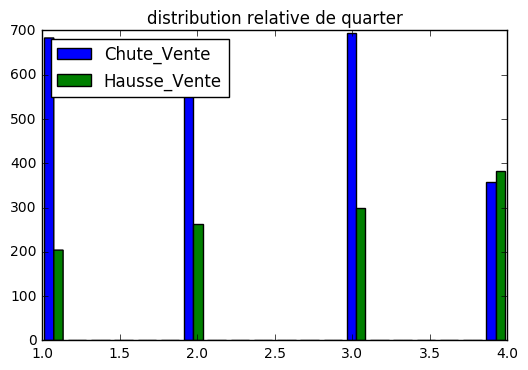

In [106]:
# Construction et appel de l'histogramme des 2 populations par rapport à variable "quarter"
def plot_hist(feature, bins = 20):
    x1 = array(baisse[feature].dropna())
    x2 = array(hausse[feature].dropna())
    plt.hist([x1,x2], label=['Chute_Vente', 'Hausse_Vente'], bins = bins)#, color = ['', 'b'])
    plt.legend(loc = 'upper left')
    plt.title('distribution relative de %s' %feature)
    plt.show()
    
plot_hist('quarter')
# On constate que quarter 1,2,3 presente une nombre tres eleve de baisse tandis que 
# 4 presente un nombre de hausse +important (dernier trimestre de l'année on achete beaucoup plus)
# Il faut donc One Hot Encodé cette variable ce qui equivaut au fait de la spliter avec
# la fonction get_dummies

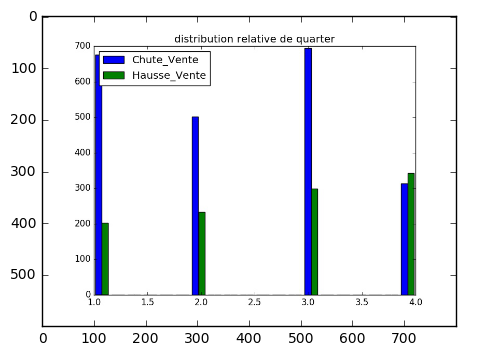

In [82]:
# Affichage du graphe dans le notebook si possible
img = plt.imread('figure_1.jpeg')
imshow(img)

## Etude de la discriminance de la variable "mois" issus de week_ending_date

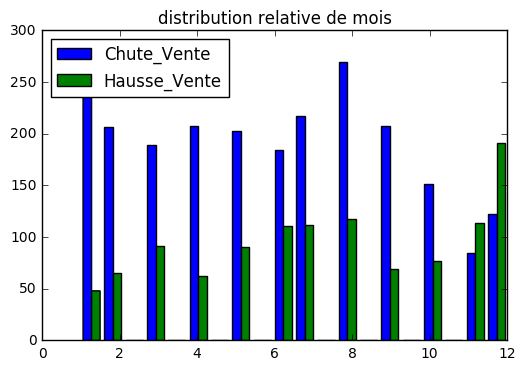

In [107]:
plot_hist('mois')

## Construction du Modele 1: regression logistique Modele 0 +ajout de "quarter" splitée

In [124]:
def parse_model_1(X):
    dum='quarter'
    target = X.Y_delta_vg
    quarter_dummies = pd.get_dummies(X['quarter'], prefix='OHE_'+dum) #one hot encoding ici
    X = X.join(quarter_dummies)
    to_del = ['Y_delta_vg','delta_vg_s','publisher', 'platform', 'game', 'genre', 'score_phrase','score',
              'score1','mois','pos','quarter']
    for col in to_del : del X[col]
    return X, target

# Appel de la fonction
X1, y1 = parse_model_1(train.copy())

# Affichage de X
X1.head()

diff_release_date  delta_gg_sm1  delta_gp_sm1  \
_id                                                                       
5853f723bcb6cea84d670b5d                 18             0            -3   
5853f723bcb6cea84d670b63                 38           -14            -3   
5853f723bcb6cea84d670b65                 43             0            -2   
5853f723bcb6cea84d670b69               1336            -9            -2   
5853f723bcb6cea84d670b6f                 37           -11             1   

                          delta_ggenre_sm1  delta_gpub_sm1  OHE_quarter_1  \
_id                                                                         
5853f723bcb6cea84d670b5d                 2              -8            0.0   
5853f723bcb6cea84d670b63               -35              -8            0.0   
5853f723bcb6cea84d670b65                17             -13            0.0   
5853f723bcb6cea84d670b69                 2              -8            0.0   
5853f723bcb6cea84d670b6f               -17             -16            0.0   

                          OHE_quarter_2  OHE_quarter_3  OHE_quarter_4  
_id                                                                    
5853f723bcb6cea84d670b5d            0.0            0.0            1.0  
5853f723bcb6cea84d670b63            0.0            0.0            1.0  
5853f723bcb6cea84d670b65            0.0            0.0            1.0  
5853f723bcb6cea84d670b69            0.0            0.0            1.0  
5853f723bcb6cea84d670b6f            0.0            0.0            1.0

In [125]:
colbar=X1.columns.values
colbar

array([u'diff_release_date', u'delta_gg_sm1', u'delta_gp_sm1',
       u'delta_ggenre_sm1', u'delta_gpub_sm1', 'OHE_quarter_1',
       'OHE_quarter_2', 'OHE_quarter_3', 'OHE_quarter_4'], dtype=object)

### Deuxieme algorithme de regression logistique (modèle 1)

In [126]:
#lr = LogisticRegression()
compute_score(lr, X1, y1) 
# score moyen pour modele 1: 0.67856404531547176 contre 0.65584294554727118 pour le modèle 0
# Soit une amélioration de 2 points ce qui n'est pas négligeable


0.67856404531547176

In [127]:
# Estimation des coefficients du modèle qui révèle le poid que la regression logistique 
#accorde à chaque variable
lr.fit(X1, y1)
a=lr.coef_[0]
print lr.coef_
# Les variables sont proche de 0 donc assez peu discriminante
# Un poid positif augmente la probabilité
# Un poid négatif diminue la probabilité
# Les split quarter sont plus discriminant que les autres variables

[[  6.77980668e-04   1.55861878e-02  -2.80280744e-04  -1.82198313e-03
    1.21710118e-03  -6.31467554e-01  -2.98225690e-01  -3.95993671e-01
    6.09059813e-01]]


## Construction du Modele 1 bis: regression logistique Modele 0 +ajout de "mois" splitée

In [129]:
def parse_model_1bis(X):
    dum='mois'
    target = X.Y_delta_vg
    mois_dummies = pd.get_dummies(X['mois'], prefix='OHE_'+dum) #one hot encoding ici
    X = X.join(mois_dummies)
    to_del = ['Y_delta_vg','delta_vg_s','quarter','publisher', 'platform', 'game', 'genre',
              'score_phrase','score','score1','mois','pos']
    for col in to_del : del X[col]
    return X, target

# Appel de la fonction
X1b, y1b = parse_model_1bis(train.copy())

# Affichage de X
X1b.head()

diff_release_date  delta_gg_sm1  delta_gp_sm1  \
_id                                                                       
5853f723bcb6cea84d670b5d                 18             0            -3   
5853f723bcb6cea84d670b63                 38           -14            -3   
5853f723bcb6cea84d670b65                 43             0            -2   
5853f723bcb6cea84d670b69               1336            -9            -2   
5853f723bcb6cea84d670b6f                 37           -11             1   

                          delta_ggenre_sm1  delta_gpub_sm1  OHE_mois_1  \
_id                                                                      
5853f723bcb6cea84d670b5d                 2              -8         0.0   
5853f723bcb6cea84d670b63               -35              -8         0.0   
5853f723bcb6cea84d670b65                17             -13         0.0   
5853f723bcb6cea84d670b69                 2              -8         0.0   
5853f723bcb6cea84d670b6f               -17             -16         0.0   

                          OHE_mois_2  OHE_mois_3  OHE_mois_4  OHE_mois_5  \
_id                                                                        
5853f723bcb6cea84d670b5d         0.0         0.0         0.0         0.0   
5853f723bcb6cea84d670b63         0.0         0.0         0.0         0.0   
5853f723bcb6cea84d670b65         0.0         0.0         0.0         0.0   
5853f723bcb6cea84d670b69         0.0         0.0         0.0         0.0   
5853f723bcb6cea84d670b6f         0.0         0.0         0.0         0.0   

                          OHE_mois_6  OHE_mois_7  OHE_mois_8  OHE_mois_9  \
_id                                                                        
5853f723bcb6cea84d670b5d         0.0         0.0         0.0         0.0   
5853f723bcb6cea84d670b63         0.0         0.0         0.0         0.0   
5853f723bcb6cea84d670b65         0.0         0.0         0.0         0.0   
5853f723bcb6cea84d670b69         0.0         0.0         0.0         0.0   
5853f723bcb6cea84d670b6f         0.0         0.0         0.0         0.0   

                          OHE_mois_10  OHE_mois_11  OHE_mois_12  
_id                                                              
5853f723bcb6cea84d670b5d          0.0          0.0          1.0  
5853f723bcb6cea84d670b63          0.0          0.0          1.0  
5853f723bcb6cea84d670b65          0.0          0.0          1.0  
5853f723bcb6cea84d670b69          0.0          0.0          1.0  
5853f723bcb6cea84d670b6f          0.0          0.0          1.0

In [130]:
#lr = LogisticRegression()
compute_score(lr, X1b, y1b) 
# score moyen pour modele 1: 0.67856404531547176 contre 0.65584294554727118 pour le modèle 0
# score moyen pour le modèle 1 bis: 0.68948772016869264 soit 1 plus de que le modèle 1
# La variable mois discrimine plus que quarter et a des modalités plus precise pour discriminer

# On la considerera à l'avenir tout en négligeant quarter

0.68948772016869264

In [142]:
# Estimation des coefficients du modèle qui révèle le poid que la regression logistique 
#accorde à chaque variable
lr.fit(X1b, y1b)
mapping={key:val for key,val in zip(X1b.columns.values,lr.coef_[0])}
print lr.coef_[0]
print X1b.columns.values
mapping

[  7.12343683e-04   1.46177703e-02  -4.33633463e-03  -2.21225426e-03
   2.59951330e-04  -1.08593070e+00  -4.93688756e-01   1.01475625e-03
  -5.21855622e-01  -1.88684118e-01   1.31339646e-01  -9.34951658e-02
  -2.72176505e-01  -4.90548365e-01   2.22291614e-03   1.04484752e+00
   1.10514237e+00]
[u'diff_release_date' u'delta_gg_sm1' u'delta_gp_sm1' u'delta_ggenre_sm1'
 u'delta_gpub_sm1' 'OHE_mois_1' 'OHE_mois_2' 'OHE_mois_3' 'OHE_mois_4'
 'OHE_mois_5' 'OHE_mois_6' 'OHE_mois_7' 'OHE_mois_8' 'OHE_mois_9'
 'OHE_mois_10' 'OHE_mois_11' 'OHE_mois_12']


{'OHE_mois_1': -1.0859307032371119,
 'OHE_mois_10': 0.0022229161361810739,
 'OHE_mois_11': 1.0448475181459096,
 'OHE_mois_12': 1.1051423708756272,
 'OHE_mois_2': -0.49368875563571846,
 'OHE_mois_3': 0.0010147562498833461,
 'OHE_mois_4': -0.52185562160817978,
 'OHE_mois_5': -0.18868411778474342,
 'OHE_mois_6': 0.13133964572372389,
 'OHE_mois_7': -0.093495165806851757,
 'OHE_mois_8': -0.27217650523753978,
 'OHE_mois_9': -0.49054836451289507,
 u'delta_gg_sm1': 0.014617770274734175,
 u'delta_ggenre_sm1': -0.0022122542646309269,
 u'delta_gp_sm1': -0.0043363346250120871,
 u'delta_gpub_sm1': 0.00025995132966756659,
 u'diff_release_date': 0.00071234368300286688}

### La variable position apporte elle une info supplémentaire pour le modèle?

In [131]:
def parse_model_2(X):
    dum='mois'
    target = X.Y_delta_vg
    mois_dummies = pd.get_dummies(X['mois'], prefix='OHE_'+dum) #one hot encoding ici
    X = X.join(mois_dummies)
    to_del = ['Y_delta_vg','delta_vg_s','quarter','publisher', 'platform', 'game', 'genre',
              'score_phrase','score','score1','mois']
    for col in to_del : del X[col]
    return X, target

# Appel de la fonction
X2, y2 = parse_model_2(train.copy())

# Affichage de X
X2.head()

pos  diff_release_date  delta_gg_sm1  delta_gp_sm1  \
_id                                                                            
5853f723bcb6cea84d670b5d    3                 18             0            -3   
5853f723bcb6cea84d670b63    6                 38           -14            -3   
5853f723bcb6cea84d670b65    7                 43             0            -2   
5853f723bcb6cea84d670b69    9               1336            -9            -2   
5853f723bcb6cea84d670b6f   12                 37           -11             1   

                          delta_ggenre_sm1  delta_gpub_sm1  OHE_mois_1  \
_id                                                                      
5853f723bcb6cea84d670b5d                 2              -8         0.0   
5853f723bcb6cea84d670b63               -35              -8         0.0   
5853f723bcb6cea84d670b65                17             -13         0.0   
5853f723bcb6cea84d670b69                 2              -8         0.0   
5853f723bcb6cea84d670b6f               -17             -16         0.0   

                          OHE_mois_2  OHE_mois_3  OHE_mois_4  OHE_mois_5  \
_id                                                                        
5853f723bcb6cea84d670b5d         0.0         0.0         0.0         0.0   
5853f723bcb6cea84d670b63         0.0         0.0         0.0         0.0   
5853f723bcb6cea84d670b65         0.0         0.0         0.0         0.0   
5853f723bcb6cea84d670b69         0.0         0.0         0.0         0.0   
5853f723bcb6cea84d670b6f         0.0         0.0         0.0         0.0   

                          OHE_mois_6  OHE_mois_7  OHE_mois_8  OHE_mois_9  \
_id                                                                        
5853f723bcb6cea84d670b5d         0.0         0.0         0.0         0.0   
5853f723bcb6cea84d670b63         0.0         0.0         0.0         0.0   
5853f723bcb6cea84d670b65         0.0         0.0         0.0         0.0   
5853f723bcb6cea84d670b69         0.0         0.0         0.0         0.0   
5853f723bcb6cea84d670b6f         0.0         0.0         0.0         0.0   

                          OHE_mois_10  OHE_mois_11  OHE_mois_12  
_id                                                              
5853f723bcb6cea84d670b5d          0.0          0.0          1.0  
5853f723bcb6cea84d670b63          0.0          0.0          1.0  
5853f723bcb6cea84d670b65          0.0          0.0          1.0  
5853f723bcb6cea84d670b69          0.0          0.0          1.0  
5853f723bcb6cea84d670b6f          0.0          0.0          1.0

In [144]:
lr2 = LogisticRegression()
print compute_score(lr2, X2, y2) 
# score moyen pour modele 1: 0.67856404531547176 contre 0.65584294554727118 pour le modèle 0
# score moyen pour le modèle 1 bis: 0.68948772016869264 soit 1 plus de que le modèle 1
# La variable mois discrimine plus que quarter et a des modalités plus precise pour discriminer
# "pos" n'apporte pas plus d'information pour le modele:0.68862482427850824

0.688624824279


In [145]:
# Estimation des coefficients du modèle qui révèle le poid que la regression logistique 
#accorde à chaque variable
lr2 = LogisticRegression()
lr2.fit(X2, y2)
mapping={key:val for key,val in zip(X2.columns.values,lr2.coef_[0])}
mapping

{'OHE_mois_1': -1.1185488905802119,
 'OHE_mois_10': 0.072951279361656185,
 'OHE_mois_11': 1.1003040360126941,
 'OHE_mois_12': 1.1068251202976014,
 'OHE_mois_2': -0.4794831739770829,
 'OHE_mois_3': 0.050102010909355413,
 'OHE_mois_4': -0.496369775033004,
 'OHE_mois_5': -0.16349962778492205,
 'OHE_mois_6': 0.13581690458552004,
 'OHE_mois_7': -0.11290939964777413,
 'OHE_mois_8': -0.26365436059812519,
 'OHE_mois_9': -0.4534504082550011,
 u'delta_gg_sm1': 0.014772718674578416,
 u'delta_ggenre_sm1': -0.0021393939798314385,
 u'delta_gp_sm1': -0.0047352588280762734,
 u'delta_gpub_sm1': 0.0002869055628807675,
 u'diff_release_date': 0.00080849557240983362,
 u'pos': -0.018891326766680729}

# Modele complet avec les categories One Hot Encodé

In [153]:
def parse_model_All(X):
    target = X.Y_delta_vg
    to_dummy = ['mois','platform','genre','score_phrase']
    for dum in to_dummy :
        split_temp = pd.get_dummies(X[dum], prefix='split_'+dum)
        for col in split_temp :
            X[col] = split_temp[col]
        del X[dum]
    to_del = ['Y_delta_vg','delta_vg_s','quarter','publisher', 'game',
              'score','score1','pos']
    for col in to_del : 
        del X[col]
    return X, target

# Appel de la fonction
XAll, yAll = parse_model_All(train.copy())

# Verif des colonnes du dataframe d'apprentissage XAll:
XAll.columns.values

array([u'diff_release_date', u'delta_gg_sm1', u'delta_gp_sm1',
       u'delta_ggenre_sm1', u'delta_gpub_sm1', 'split_mois_1',
       'split_mois_2', 'split_mois_3', 'split_mois_4', 'split_mois_5',
       'split_mois_6', 'split_mois_7', 'split_mois_8', 'split_mois_9',
       'split_mois_10', 'split_mois_11', 'split_mois_12',
       u'split_platform_3DS', u'split_platform_DS', u'split_platform_PC',
       u'split_platform_PS3', u'split_platform_PS4', u'split_platform_PSV',
       u'split_platform_Wii', u'split_platform_WiiU',
       u'split_platform_X360', u'split_platform_XOne',
       u'split_genre_Action', u'split_genre_Adventure',
       u'split_genre_Fighting', u'split_genre_Platform',
       u'split_genre_Racing', u'split_genre_Role-Playing',
       u'split_genre_Shooter', u'split_genre_Simulation',
       u'split_genre_Sports', u'split_genre_Strategy',
       u'split_score_phrase_Amazing', u'split_score_phrase_Bad',
       u'split_score_phrase_Good', u'split_score_phrase_Great',
 

In [154]:
lrAll = LogisticRegression()
print compute_score(lrAll, XAll, yAll) 
# score moyen pour modele 1: 0.67856404531547176 contre 0.65584294554727118 pour le modèle 0
# score moyen pour le modèle 1 bis: 0.68948772016869264 soit 1 plus de que le modèle 1
# La variable mois discrimine plus que quarter et a des modalités plus precise pour discriminer
# "pos" n'apporte pas plus d'information pour le modele:0.68862482427850824
# Moins bon modèle score_moyen de: 0.67337178533

0.67337178533


In [157]:
# Poids des coeff:
lrAll.fit(XAll, yAll)
mapping={}
mapping={key:val for key,val in zip(XAll.columns.values,lrAll.coef_[0])}
mapping

{u'delta_gg_sm1': 0.012747280080002903,
 u'delta_ggenre_sm1': -0.0021637009447781018,
 u'delta_gp_sm1': -0.0048309937815475537,
 u'delta_gpub_sm1': -0.00013333037877625648,
 u'diff_release_date': 0.00079394856470944744,
 u'split_genre_Action': -0.075527960099010139,
 u'split_genre_Adventure': -0.5083379803942556,
 u'split_genre_Fighting': 0.39598021358389601,
 u'split_genre_Platform': -0.14901787005170547,
 u'split_genre_Racing': -0.024865339832184027,
 u'split_genre_Role-Playing': 0.2533017013098347,
 u'split_genre_Shooter': 0.20853469830081162,
 u'split_genre_Simulation': 0.11236577299089902,
 u'split_genre_Sports': -0.255866407953666,
 u'split_genre_Strategy': -0.88080843350838389,
 'split_mois_1': -1.0954650337581617,
 'split_mois_10': -0.0027048353855570716,
 'split_mois_11': 1.1440448495915136,
 'split_mois_12': 1.2084037934085203,
 'split_mois_2': -0.45799146216282965,
 'split_mois_3': 0.0055542185049961374,
 'split_mois_4': -0.51657849172589299,
 'split_mois_5': -0.242862336714

# Appelons Random Forest à notre secours

In [165]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

print compute_score(rf, X, y) #0.623912594063
print compute_score(rf, X1, y1)  #0.652376994956
print compute_score(rf, X1b, y1b) #0.663876209377
print compute_score(rf, X2, y2) #0.671646407012 introduction de "pos" donc de non linearité dans le modele
print compute_score(rf, XAll, yAll) #0.646321012156

0.623912594063
0.652376994956
0.663876209377
0.671646407012
0.646321012156


### Importance relative des variables car plus acces aux poids des variables

In [171]:
def clf_importance(X, clf):
    import pylab as pl
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    pl.title("Feature importances")
    for tree in clf.estimators_:
        pl.plot(xrange(X.shape[1]), tree.feature_importances_[indices], "r")
        pl.plot(xrange(X.shape[1]), importances[indices], "b")
        pl.show();
    for f in range(X.shape[1]):
        print("%d. feature : %s (%f)" % (f+1, X.columns[indices[f]], importances[indices[f]]))
        

        

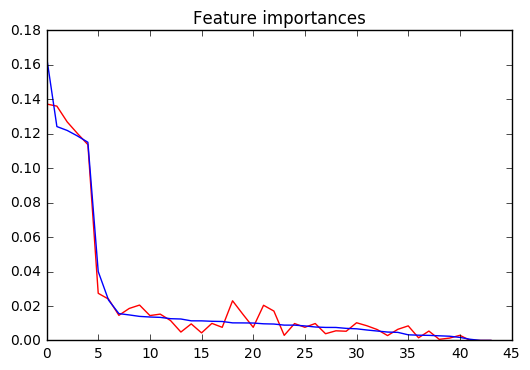

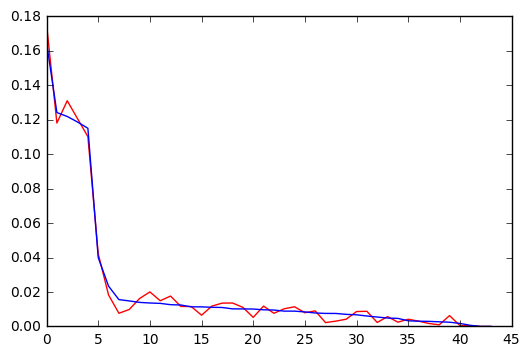

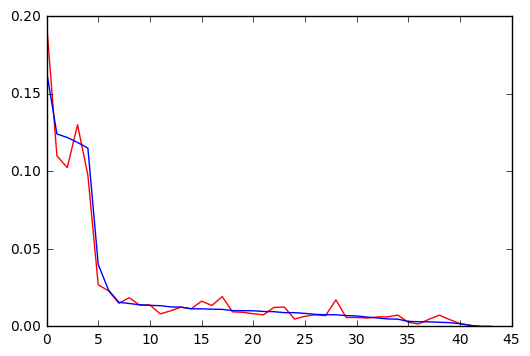

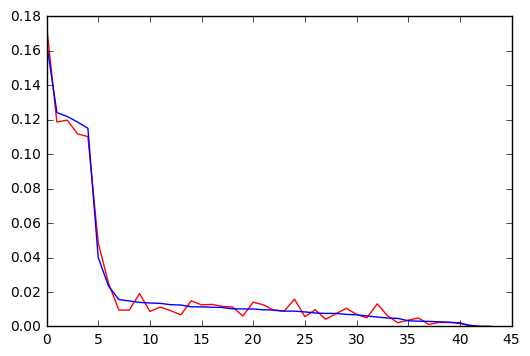

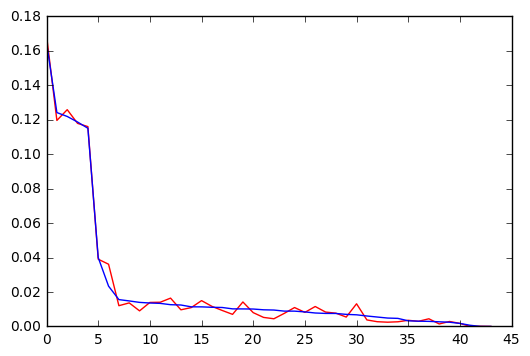

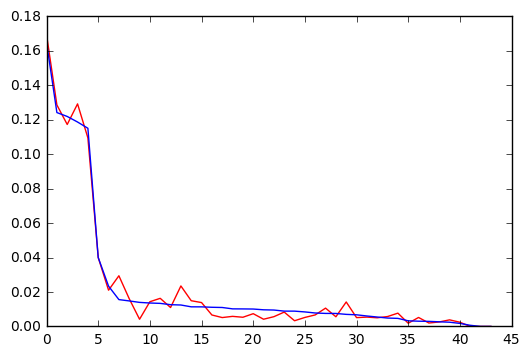

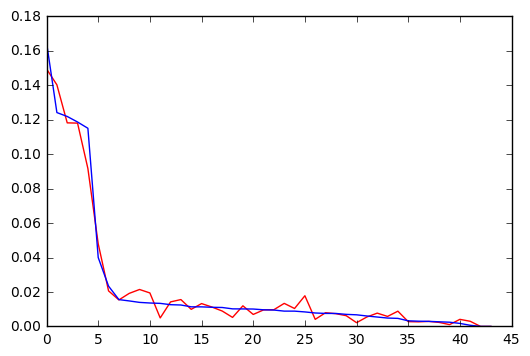

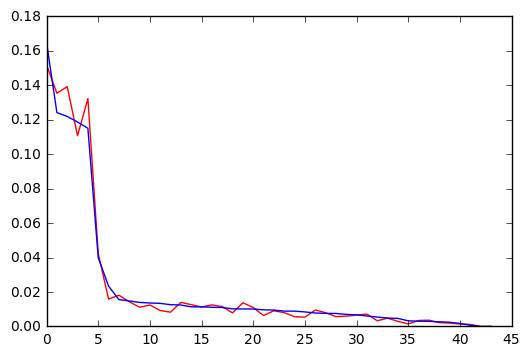

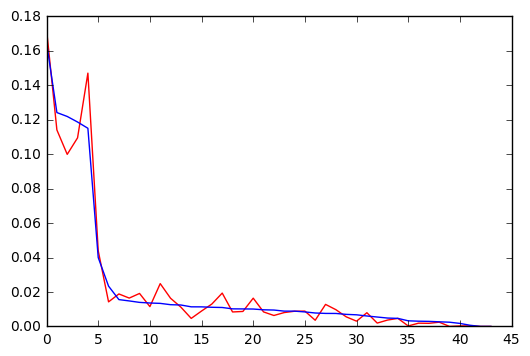

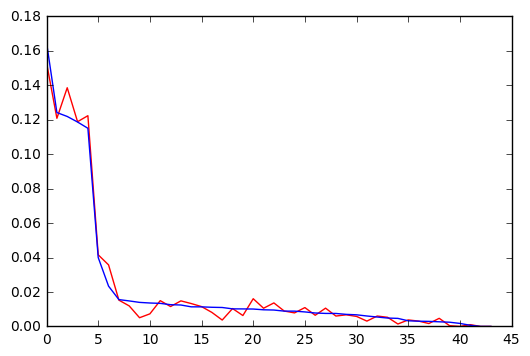

1. feature : diff_release_date (0.164834)
2. feature : delta_ggenre_sm1 (0.124189)
3. feature : delta_gp_sm1 (0.121927)
4. feature : delta_gg_sm1 (0.118696)
5. feature : delta_gpub_sm1 (0.115064)
6. feature : split_mois_12 (0.039999)
7. feature : split_mois_11 (0.023403)
8. feature : split_score_phrase_Amazing (0.015586)
9. feature : split_score_phrase_Great (0.014816)
10. feature : split_platform_PS3 (0.013966)
11. feature : split_mois_8 (0.013610)
12. feature : split_platform_3DS (0.013396)
13. feature : split_mois_7 (0.012632)
14. feature : split_mois_1 (0.012450)
15. feature : split_mois_3 (0.011390)
16. feature : split_mois_6 (0.011369)
17. feature : split_platform_PS4 (0.011130)
18. feature : split_mois_4 (0.011005)
19. feature : split_genre_Action (0.010208)
20. feature : split_genre_Racing (0.010176)
21. feature : split_genre_Role-Playing (0.010109)
22. feature : split_genre_Shooter (0.009667)
23. feature : split_platform_X360 (0.009525)
24. feature : split_mois_2 (0.008898)
25

In [172]:
# On reappelle un RandomForest entrainé pour modele complet
rf.fit(XAll, yAll)
clf_importance(XAll, rf)

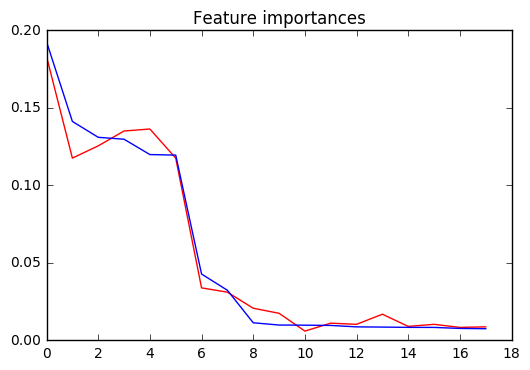

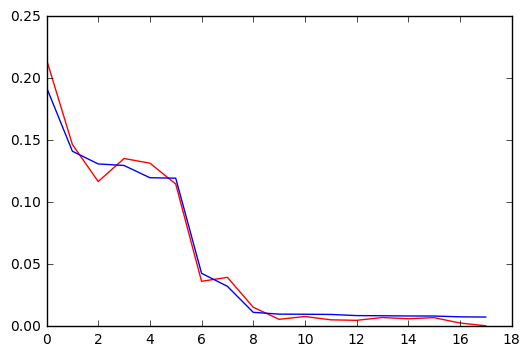

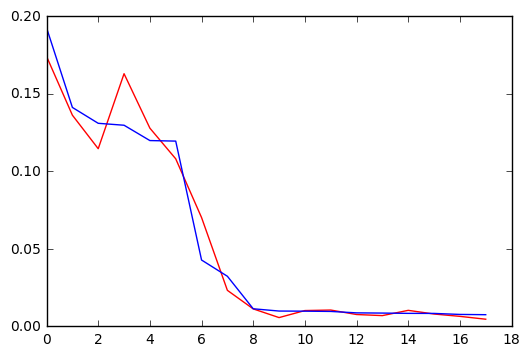

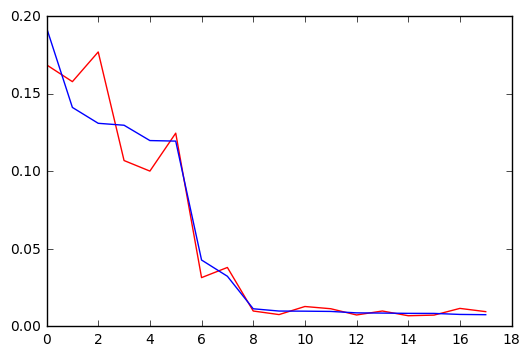

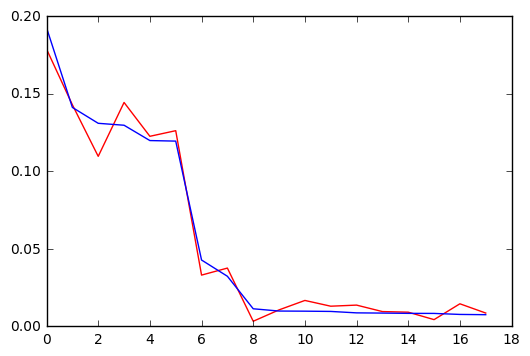

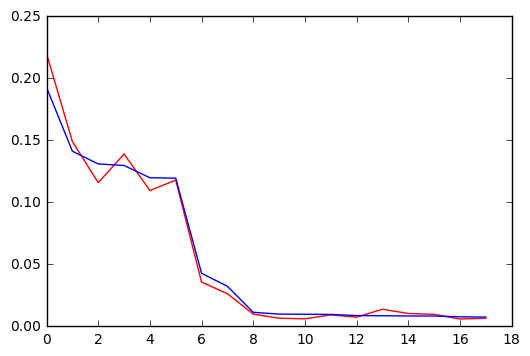

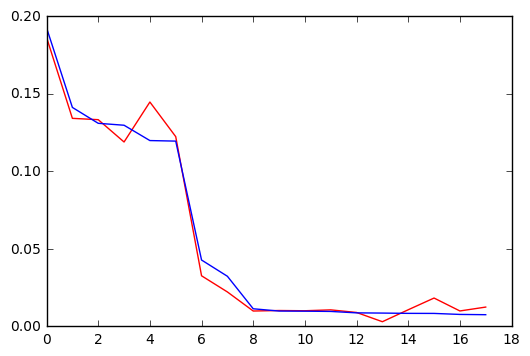

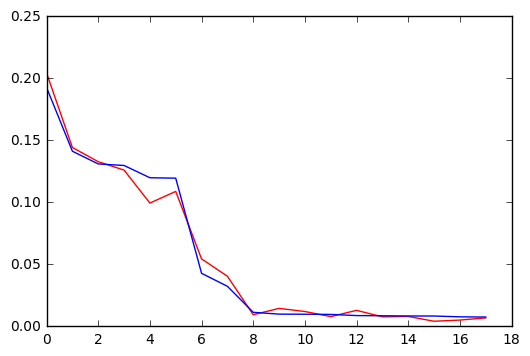

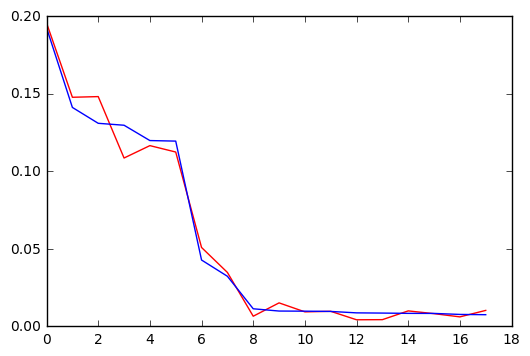

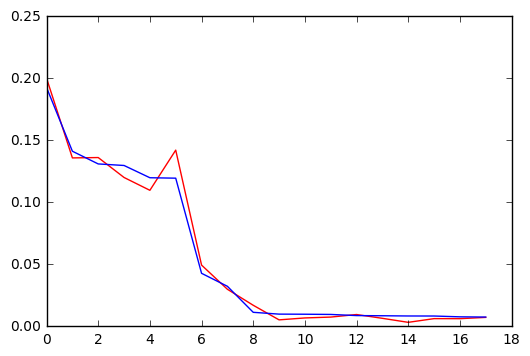

1. feature : diff_release_date (0.192683)
2. feature : delta_gg_sm1 (0.141300)
3. feature : delta_gpub_sm1 (0.131058)
4. feature : delta_gp_sm1 (0.129810)
5. feature : delta_ggenre_sm1 (0.119923)
6. feature : pos (0.119573)
7. feature : OHE_mois_12 (0.042853)
8. feature : OHE_mois_11 (0.032373)
9. feature : OHE_mois_1 (0.011398)
10. feature : OHE_mois_6 (0.009933)
11. feature : OHE_mois_3 (0.009853)
12. feature : OHE_mois_8 (0.009685)
13. feature : OHE_mois_4 (0.008761)
14. feature : OHE_mois_10 (0.008622)
15. feature : OHE_mois_9 (0.008440)
16. feature : OHE_mois_5 (0.008405)
17. feature : OHE_mois_2 (0.007751)
18. feature : OHE_mois_7 (0.007578)


In [173]:
# On reappelle un RandomForest entrainé Modele 2
rf.fit(X2, y2)
clf_importance(X2, rf)